### chr10 core-cenhap analysis
In this notebook, normalized counts of cenhap-specific k-mers are used to train a Random Forest classifier, with each cenhap treated as an independent target in a multi-label classification setting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

# Train model

In [2]:
# Set names of clade-specific kmers
h1_kmer = 'cen6h1-1'
h2_kmer = 'cen6h2-1'

In [3]:
# Load and normalize input k-mer count data in 1000 Genomes
raw_counts = pd.read_csv('inputs/modern_counts.tsv', sep='\t').set_index('id')
norm_counts = raw_counts.div(raw_counts[h1_kmer] + raw_counts[h2_kmer], axis=0)

# sum ch1 k-mers
norm_counts['ch1_sum'] = norm_counts['ch1-1'] + norm_counts['ch1-2']

# select kmers for prediction
selected_kmers = ['ch1-1', 'ch1-2', 'ch10-1', 'ch10-2', 'ch14-1', 'ch14-2', 'ch2-1', 'ch2-2', 'ch3-1', 'ch3-2', 'ch4-1', 'ch4-2', 'ch7-1', 'ch7-2', 'ch8-1', 'ch8-2']
norm_counts = norm_counts.loc[:, selected_kmers]

# Load haplotype labels
metadata = pd.read_csv('inputs/metadata.tsv', sep='\t').set_index('id')
flank_cenhaps = metadata[['mat_cenhap', 'pat_cenhap']].dropna().map(lambda x: str(int(x)))
number_of_cenhaps = len(set(np.concatenate((flank_cenhaps['mat_cenhap'], flank_cenhaps['pat_cenhap']))))

# Keep only samples with haplotype assignments
norm_counts = norm_counts.loc[flank_cenhaps.index]

In [4]:
# Encode haplotype targets and split the dataset
hap_classes = [str(i) for i in range(1, number_of_cenhaps+1)]
mlb = MultiLabelBinarizer(classes=hap_classes)
Y = mlb.fit_transform(flank_cenhaps.values)
X = norm_counts.values

# train/test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, norm_counts.index, test_size=0.2, random_state=42
)

# add train/test status of sample to metadata
metadata.loc[idx_train, 'subsample'] = 'train'
metadata.loc[idx_test, 'subsample'] = 'test'

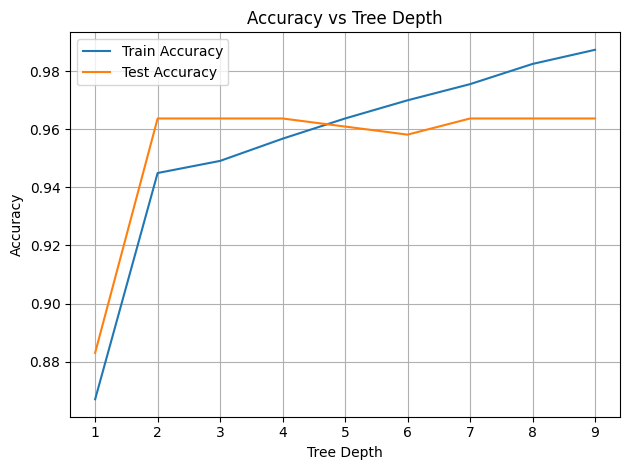

In [5]:
# Plot accuracy vs tree depth to detect overfitting
depths = list(range(1, 10))
train_acc = []
test_acc = []

for depth in depths:
    clf = MultiOutputClassifier(RandomForestClassifier(max_depth=depth, n_estimators=100, random_state=42))
    clf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, clf.predict(X_train)))
    test_acc.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(depths, train_acc, label='Train Accuracy')
plt.plot(depths, test_acc, label='Test Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Let's pick depth 4 for not to get too overfit

In [6]:
# Train final model with chosen depth and evaluate accuracy
model = MultiOutputClassifier(RandomForestClassifier(max_depth=4, n_estimators=100, random_state=42))
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9568
Test accuracy: 0.9638


In [7]:
# Compute and display feature importance table
importances = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)
feature_importance = pd.DataFrame({
    'kmer': norm_counts.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
feature_importance

,kmer,importance
5,ch14-2,0.095313
1,ch1-2,0.085897
13,ch7-2,0.072718
9,ch3-2,0.070436
7,ch2-2,0.068849
11,ch4-2,0.067402
6,ch2-1,0.066174
12,ch7-1,0.063185
8,ch3-1,0.060453
10,ch4-1,0.058198


# Predict core-cenhaps

### Prediction function

In [8]:
# Prediction function
def predict_core_cenhap(path_to_counts_file):

    # Load counts
    raw_counts = pd.read_csv(path_to_counts_file, sep='\t').set_index('id')

    # Normalize counts by h1_kemr + h2_kmer
    norm_counts = raw_counts.div(raw_counts[h1_kmer] + raw_counts[h2_kmer], axis=0)

    # sum ch1 k-mers
    norm_counts['ch1_sum'] = norm_counts['ch1-1'] + norm_counts['ch1-2']

    # select kmers for prediction
    norm_counts = norm_counts.loc[:, selected_kmers]
    
    # Predict using the trained model
    X_new = norm_counts[norm_counts.columns].values
    y_pred = model.predict(X_new)
    
    # Convert to string labels
    core_cenhaps = pd.DataFrame(index=raw_counts.index)
    pred_labels = mlb.inverse_transform(y_pred)
    core_cenhaps['core_cenhap'] = [','.join(sorted(haps)) for haps in pred_labels]

    # Get class probabilities
    y_proba = model.predict_proba(X_new)
    for i in range(len(y_pred)):
        core_cenhaps_index = core_cenhaps.index[i]
        probs = []
        for cenhap_index in np.where(y_pred[i] == 1)[0]:
            cenhap_prob = str(round(y_proba[cenhap_index][i][1], 3))
            probs.append(cenhap_prob)
        probs = ', '.join(probs)
        core_cenhaps.loc[core_cenhaps_index, 'prob'] = probs

    # homoygots predictions 'n' --> 'n,n'
    core_cenhaps['core_cenhap'] = core_cenhaps['core_cenhap'].astype(str).apply(
        lambda x: f"{x},{x}" if ',' not in x else x
    )

    return raw_counts, (norm_counts*100).round(5), core_cenhaps

### Modern samples analysis

In [9]:
# predict all 3202 1000 Genomes samples
raw_counts, norm_counts, core_cenhaps = predict_core_cenhap('inputs/modern_counts.tsv')

# convert flank-cenhaps to match core-cenhaps format
flank_cenhaps['flank_cenhap'] = flank_cenhaps[['mat_cenhap', 'pat_cenhap']].apply(
    lambda row: ','.join(map(str, sorted([row['mat_cenhap'], row['pat_cenhap']]))), axis=1
)

# concatinate flank-cenhaps and core-cenhaps
cenhaps = pd.concat([flank_cenhaps[['flank_cenhap']], core_cenhaps], axis=1)

# check errors
cenhaps_half = cenhaps.dropna()
cenhaps_half['match'] = cenhaps_half['flank_cenhap'] == cenhaps_half['core_cenhap']
mismatches = cenhaps_half[cenhaps_half['match'] == False]
print(f'Total accuracy: {round(1 - len(mismatches) / len(cenhaps_half), 3)}')

Total accuracy: 0.958


/tmp/ipykernel_56441/722629435.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cenhaps_half['match'] = cenhaps_half['flank_cenhap'] == cenhaps_half['core_cenhap']


In [10]:
# mismatches frequency table
cnt_mismatches = Counter(mismatches['flank_cenhap'] + '_' + mismatches['core_cenhap'])
cnt_mismatches = pd.DataFrame(cnt_mismatches, index=['cnt']).T.sort_values('cnt', ascending=False)
cnt_mismatches.to_csv('outputs/mismatches_stats.tsv', sep='\t')
cnt_mismatches.head()

,cnt
"4,6_2,4",14
"1,6_1,2",13
"2,6_2,2",13
"6,8_2,8",4
"4,4_1,4",3


In [11]:
# create final resulting table

# h1h2 counts
h1h2_kmers = raw_counts[[h1_kmer, h2_kmer]].div(raw_counts[h1_kmer] + raw_counts[h2_kmer], axis=0).round(5)

# assemble resulting table
modern_results = pd.concat([metadata, cenhaps, cenhaps_half['match'], h1h2_kmers, norm_counts], axis=1).sort_index()

# fix types
modern_results['mat_cenhap'] = modern_results['mat_cenhap'].apply(pd.to_numeric, errors='coerce').astype('Int64')
modern_results['pat_cenhap'] = modern_results['pat_cenhap'].apply(pd.to_numeric, errors='coerce').astype('Int64')

# save table
modern_results.to_csv('outputs/modern_results.tsv', sep='\t')
modern_results.head()

,pop,super_pop,sex,mat_cenhap,pat_cenhap,subsample,flank_cenhap,core_cenhap,prob,match,...,ch2-1,ch2-2,ch3-1,ch3-2,ch4-1,ch4-2,ch7-1,ch7-2,ch8-1,ch8-2
id,,,,,,,,,,,,,,,,,,,,,
HG00096,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,"1,4","0.959, 0.974",NaN,...,0.02505,0.03758,0.31943,0.04384,9.54528,22.41638,0.07829,0.38519,0.0,0.17537
HG00097,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,"2,2",0.949,NaN,...,78.36067,42.41069,0.43279,0.12673,0.11477,0.38736,0.07651,0.56191,0.0,0.30606
HG00099,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,"1,2","0.982, 0.945",NaN,...,59.75580,31.83951,0.40700,0.13122,0.14012,0.54044,0.06450,0.40923,0.0,0.36030
HG00100,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,"4,4",0.995,NaN,...,0.02254,0.06388,0.33817,0.05260,17.94544,37.59675,0.09394,0.36447,0.0,0.51477
HG00101,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,"1,2","0.968, 0.961",NaN,...,57.61596,30.62725,0.54795,0.14179,0.19226,0.43739,0.09373,0.48786,0.0,0.61764


### Archaic samples analysis

In [12]:
raw_counts, norm_counts, core_cenhaps = predict_core_cenhap('inputs/archaic_counts.tsv')

In [13]:
# h1h2 counts
h1h2_kmers = raw_counts[[h1_kmer, h2_kmer]].div(raw_counts[h1_kmer] + raw_counts[h2_kmer], axis=0).round(5)

# resulting table
archaic_results = pd.concat([core_cenhaps, h1h2_kmers, norm_counts], axis=1)
archaic_results.to_csv('outputs/archaic_results.tsv', sep='\t')
archaic_results

,core_cenhap,prob,cen6h1-1,cen6h2-1,ch1-1,ch1-2,ch10-1,ch10-2,ch14-1,ch14-2,ch2-1,ch2-2,ch3-1,ch3-2,ch4-1,ch4-2,ch7-1,ch7-2,ch8-1,ch8-2
id,,,,,,,,,,,,,,,,,,,,
Denisova,"14,4","0.502, 0.504",0.49264,0.50736,0.00000,0.00000,1.47256,0.0,0.26774,86.27845,0.00000,0.00000,0.33467,0.00000,7.96519,0.00000,0.13387,1.00402,0.00000,0.87015
Altai,"7,7",0.898,0.97672,0.02328,0.06126,0.07351,2.16246,0.0,0.01225,0.12252,0.07351,0.03063,0.13477,0.08576,0.04901,0.10414,19.40088,47.78853,0.00000,1.59887
Chag,"7,7",0.936,0.96528,0.03472,0.00000,0.00000,0.55159,0.0,0.00000,0.03245,0.03245,0.00000,0.12979,0.03245,0.03245,0.03245,21.90136,40.03894,0.00000,1.13563
GoyetQ56-1,"7,7",0.922,0.96739,0.03261,0.07764,0.10352,0.95756,0.0,0.00000,0.02588,0.15528,0.12940,0.02588,0.20704,0.02588,0.05176,21.06625,36.62008,0.00000,0.43996
Hohlenstein-Stadel,"1,7","0.69, 0.897",0.96667,0.03333,0.00000,2.33333,0.00000,0.0,0.00000,0.00000,0.66667,0.00000,0.66667,1.66667,0.33333,0.33333,10.33333,44.33333,0.00000,1.00000
LesCottes_Z4-1514,"7,7",0.902,0.97712,0.02288,0.05651,0.02825,0.73457,0.0,0.00000,0.11301,0.07063,0.02825,0.15539,0.01413,0.09888,0.08476,17.05043,56.51928,0.05651,1.51151
Mezmaiskaya1,"7,7",0.835,0.97284,0.02716,0.74074,0.00000,1.72840,0.0,0.00000,0.49383,2.96296,0.74074,0.00000,0.00000,0.24691,0.00000,30.37037,58.76543,0.00000,0.98765
Mezmaiskaya2,"7,7",0.88,0.97333,0.02667,0.06612,0.00000,0.50694,0.0,0.04408,0.41878,0.11020,0.00000,0.11020,0.02204,0.06612,0.08816,19.30791,38.50562,0.04408,0.55102
Scladina,"2,4,7","0.604, 0.666, 0.921",0.90196,0.09804,1.96078,0.00000,0.00000,0.0,0.00000,0.00000,15.68627,5.88235,0.00000,0.00000,0.00000,1.96078,5.88235,37.25490,0.00000,0.00000
